# Basic Demo for D-Wave on Braket: The Minimum Vertex Cover Problem

In this tutorial we discuss both the ```BraketSampler``` and ```BraketDWaveSampler```. In essence, they are both doing the same thing; each one just accepts different parameter names. Specifcally, the ```BraketDWaveSampler``` allows users familiar with D-Wave to use D-Wave parameter names, e.g., ```answer_mode```, whereas the ```BraketSampler``` parameter names are consistent with the rest of the Braket experience. 

Here we consider a well-known combinatorial optimization problem on graphs called the Minimum Vertex Cover problem. Given an undirected graph with a vertex set $V$ and an edge set $E$, a vertex cover is a subset of the vertices (nodes) such that each edge in the graph is incident to at least one vertex in the subset. The Minimum Vertex Cover problem seeks to find a cover with a minimum number of vertices in the subset.

Instructions available here: https://github.com/aws/braket-ocean-python-plugin

In [1]:
import boto3
import json
from braket.aws import AwsSession, AwsQpu
from braket.ocean_plugin import BraketSamplerArns, BraketSampler, BraketDWaveSampler

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import dwave_networkx as dnx
from dimod.binary_quadratic_model import BinaryQuadraticModel
from dwave.system.composites import EmbeddingComposite

In [3]:
# set up S3 bucket (where results are stored)
my_bucket = "braket-bravehearts" # enter your bucket name here
my_prefix = "dwave-output" # enter your prefix key here
s3_folder = (my_bucket, my_prefix)

In [4]:
# session and backend
aws_session = AwsSession()
device = AwsQpu("arn:aws:aqx:::qpu:d-wave")
print('Device backend:\n', device)

Device backend:
 QPU('name': D-Wave, 'arn': arn:aws:aqx:::qpu:d-wave)


In [5]:
# print D-Wave device properties
for prop in device.properties:
    print(prop)

annealingDurationRange
annealingOffsetRanges
annealingOffsetStep
annealingOffsetStepPhi0
couplers
defaultAnnealingDuration
defaultProgrammingThermalizationDuration
defaultReadoutThermalizationDuration
extendedJRange
hGainScheduleRange
hRange
jRange
maximumAnnealingSchedulePoints
maximumHGainSchedulePoints
perQubitCouplingRange
programmingThermalizationDurationRange
qubitCount
qubits
quotaConversionRate
readoutThermalizationDurationRange
shotsRange
taskRunDurationRange
topology


## HELPER FUNCTIONS

In [6]:
# helper function to get colors for every node
def get_colors(result, n):
    """
    return list of colors=[0, 0, 1, 0, 1, 1, ...] for graph
    """
    # Obtain colors of each vertex
    colors = [0 for _ in range(n)]
    for ii in range(n):
        if ii in result:
            colors[ii] = 1
    
    return colors


In [7]:
# helper function to plot graph
def get_graph(graph, pos):
    """
    plot graph with labels
    """
    # positions for all nodes
    # pos = nx.spring_layout(graph)

    # nodes
    nx.draw_networkx_nodes(graph, pos, node_size=700)

    # edges
    nx.draw_networkx_edges(graph, pos)

    # labels
    nx.draw_networkx_labels(graph, pos, font_size=20, font_family='sans-serif')

    # plot the graph
    plt.axis('off')
    #plt.savefig("figures/random_graph.png") # save as png
    plt.show();

In [8]:
# helper function to plot graph
def get_colored_graph(graph, pos, colors):
    """
    plot colored graph for given solution
    """
    
    # positions for all nodes
    # pos = nx.spring_layout(graph)
    
    colorlist = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628', '#f781bf']
    nx.draw_networkx(graph, pos, node_color=[colorlist[colors[int(node)]] for node in graph.nodes],
                     node_size=400, font_weight='bold', font_color='w')
    # plot the graph
    plt.axis('off');
    # plt.savefig("./figures/weighted_graph.png") # save as png


## BRAKET SAMPLER: Minimum Vertex Cover Problem

A ```sampler```, as defined [here](https://docs.ocean.dwavesys.com/en/latest/glossary.html#term-sampler) and [here](https://docs.ocean.dwavesys.com/projects/system/en/stable/reference/samplers.html), accepts a binary quadratic model (```BQM```) and returns variable assignments. Samplers generally try to find minimizing values but can also sample from distributions defined by the ```BQM```: Samplers are processes that sample from low energy states of a problem’s objective function, which is a mathematical expression of the energy of a system. A binary quadratic model (BQM) sampler samples from low energy states in models such as those defined by an Ising equation or a QUBO problem and returns an iterable of samples, in order of increasing energy.

```BraketSampler``` is a structured sampler that uses Braket-formatted parameters and properties. For example, instead of ```answer_mode```, which is used for D-Wave QPU samplers, Braket uses ```resultFormat``` instead. Below is a sample example of solving the minimum vertex cover problem using ```BraketSampler```.

In [9]:
# set sampler
sampler = BraketSampler(s3_folder, BraketSamplerArns.DWAVE)

# EmbeddingComposite automatically maps the problem to the structure of the solver.
embedded_sampler = EmbeddingComposite(sampler)

### Minimum Vertex Cover Problem: Star Graph

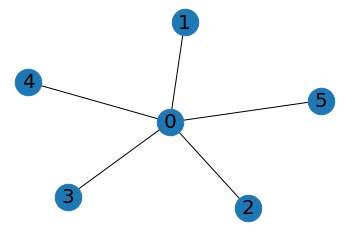

In [10]:
# set graph
n = 6
graph = nx.star_graph(n-1) 
# positions for all nodes
pos = nx.spring_layout(graph)

# plot graph with labels
get_graph(graph, pos)

Result to MVC problem: [0]


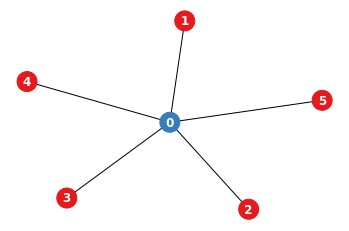

In [11]:
# run problem on D-Wave
result = dnx.min_vertex_cover(graph, embedded_sampler, resultFormat="HISTOGRAM")
print('Result to MVC problem:', result)

# get coloring
colors = get_colors(result, n)

# plot result
get_colored_graph(graph, pos, colors)

### Minimum Vertex Cover Problem: Erdos Renyi graph

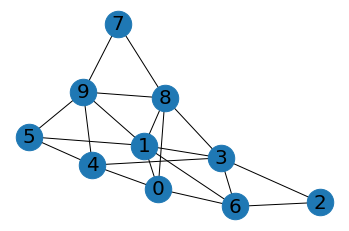

In [12]:
# setup Erdos Renyi graph
n = 10  # 10 nodes
m = 20  # 20 edges

# set graph
graph = nx.gnm_random_graph(n, m, seed=42)
# positions for all nodes
pos = nx.spring_layout(graph)

# plot graph with labels
get_graph(graph, pos)

Result to MVC problem: [0, 3, 5, 6, 8, 9]


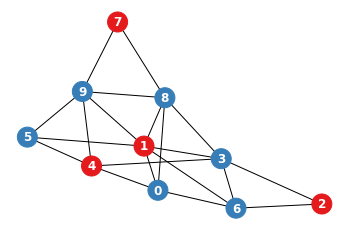

In [13]:
# run problem on D-Wave
result = dnx.min_vertex_cover(graph, embedded_sampler, resultFormat="HISTOGRAM")
print('Result to MVC problem:', result)

# get coloring
colors = get_colors(result, n)

# plot result
get_colored_graph(graph, pos, colors)

## BRAKET D-WAVE SAMPLER: Minimum Vertex Cover Problem

```BraketDWaveSampler``` is a structured sampler that uses D-Wave-formatted parameters and properties. It is interchangeable with D-Wave's ```DWaveSampler```. Below is the same example as above of solving the minimum vertex cover problem. Only the parameter inputs to the solver have been changed to be D-Wave formatted (e.g. ```answer_mode``` instead of ```resultFormat```).

In [14]:
# set sampler
sampler = BraketDWaveSampler(s3_folder, BraketSamplerArns.DWAVE)

# EmbeddingComposite automatically maps the problem to the structure of the solver.
embedded_sampler = EmbeddingComposite(sampler)

Result to MVC problem: [0, 3, 5, 6, 8, 9]


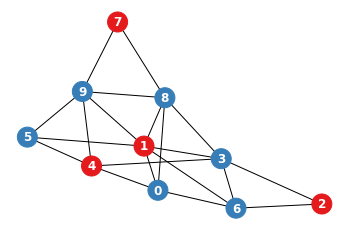

In [15]:
# run problem on D-Wave: note replacement of 'resultFormat' with 'answer_mode'
result = dnx.min_vertex_cover(graph, embedded_sampler, answer_mode="histogram")
print('Result to MVC problem:', result)

# get coloring
colors = get_colors(result, n)

# plot result
get_colored_graph(graph, pos, colors)

---
## APPENDIX

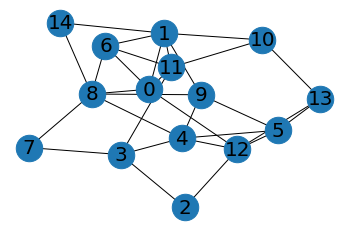

Result to MVC problem: [0, 1, 3, 5, 8, 9, 11, 12, 13]


In [16]:
# set sampler
sampler = BraketSampler(s3_folder, BraketSamplerArns.DWAVE)

# EmbeddingComposite automatically maps the problem to the structure of the solver.
embedded_sampler = EmbeddingComposite(sampler)

# setup Erdos Renyi graph
n = 15  # 10 nodes
m = 30  # 20 edges

# set graph
graph = nx.gnm_random_graph(n, m, seed=42)
# positions for all nodes
pos = nx.spring_layout(graph)
# plot graph with labels
get_graph(graph, pos)

# The below result should be 0 because node 0 is connected to the 4 other nodes in a star graph
result = dnx.min_vertex_cover(graph, embedded_sampler, resultFormat="HISTOGRAM")
print('Result to MVC problem:', result)

In [17]:
# Obtain colors of each vertex
colors = [0 for _ in range(n)]
for ii in range(n):
    if ii in result:
        colors[ii] = 1

print(colors)

[1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0]


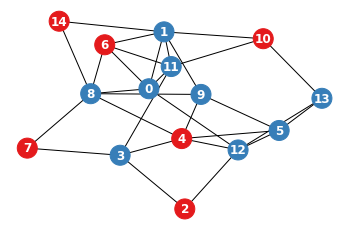

In [18]:
# plot result
get_colored_graph(graph, pos, colors)

In [19]:
print(graph.edges)

[(0, 11), (0, 6), (0, 1), (0, 8), (0, 12), (1, 10), (1, 11), (1, 9), (1, 6), (1, 14), (2, 3), (2, 12), (3, 4), (3, 11), (3, 7), (4, 9), (4, 5), (4, 12), (4, 8), (5, 12), (5, 13), (5, 9), (6, 8), (6, 11), (7, 8), (8, 14), (8, 9), (10, 11), (10, 13), (12, 13)]


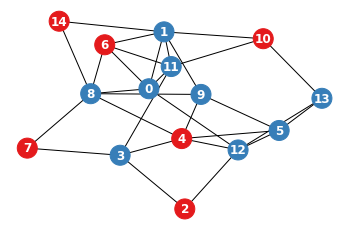

In [20]:
colorlist = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628', '#f781bf']
nx.draw_networkx(graph, pos, node_color=[colorlist[colors[int(node)]] for node in graph.nodes],
                 node_size=400, font_weight='bold', font_color='w')
# plot the graph
plt.axis('off');
# plt.savefig("./figures/weighted_graph.png") # save as png
# plt.show();

### APPENDIX: Packages

In [21]:
! pip freeze

alabaster==0.7.12
anaconda-client==1.7.2
anaconda-project==0.8.3
appdirs==1.4.3
asn1crypto==1.3.0
astroid==2.3.3
astropy==4.0
atomicwrites==1.3.0
attrs==19.3.0
Babel==2.8.0
backcall==0.1.0
backports.shutil-get-terminal-size==1.0.0
beautifulsoup4==4.8.2
bitarray==1.2.1
bkcharts==0.2
blaze==0.11.3
bleach==3.1.0
bokeh==1.0.4
boltons==20.0.0
boto==2.49.0
boto3==1.10.19
botocore==1.13.19
Bottleneck==1.3.2
# Editable install with no version control (braket-ir==0.2.2)
-e /home/ec2-user/SageMaker/braket-python-ir/src
# Editable install with no version control (braket-ocean-plugin==0.1.1)
-e /home/ec2-user/SageMaker/braket-ocean-python-plugin/src
# Editable install with no version control (braket-sdk==0.3.2)
-e /home/ec2-user/SageMaker/braket-python-sdk/src
certifi==2019.11.28
cffi==1.14.0
chardet==3.0.4
Click==7.0
cloudpickle==1.3.0
clyent==1.2.2
colorama==0.4.3
contextlib2==0.6.0.post1
cryptography==2.8
cycler==0.10.0
Cython==0.29.15
cytoolz==0.10.1
dask==2.12.0
datashape==0.5.4
decorator==4.

In [22]:
! which python

/home/ec2-user/anaconda3/envs/python3/bin/python


In [23]:
! python --version

Python 3.7.6
